In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Path to the 'data' folder
data_folder = "data"

# List to store image info
data = []

# Iterate through images in the 'data' folder
for filename in sorted(os.listdir(data_folder)):  # Sort for consistency
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):  # Check for valid images
        label = 1 if filename.startswith("fp_") else 0  # Assign label based on prefix
        data.append([filename, label])

# Create DataFrame
df = pd.DataFrame(data, columns=["filename", "label"])

In [3]:
df["index"] = range(1, len(df) + 1)
df = df[["index"] + [col for col in df.columns if col != "index"]]

In [4]:
from scipy.stats import kurtosis, entropy

In [5]:
def compute_entropy(path):
    """
    Compute the entropy of an image.
    """
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    hist = cv2.calcHist([image], [0], None, [256], [0, 256]).flatten()
    hist_entropy = entropy(hist + 1e-10)
    return float(hist_entropy)  # Calculate entropy

def compute_kurtosis(path):
    """
    Compute the kurtosis of an image.
    """ 
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    hist = cv2.calcHist([image], [0], None, [256], [0, 256]).flatten()
    return float(kurtosis(hist))  # Calculate kurtosis

def compute_variance(path):
    """
    Compute the variance of an image.
    """
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    hist = cv2.calcHist([image], [0], None, [256], [0, 256]).flatten()
    return float(np.var(hist))  # Calculate variance

In [6]:
def get_height_width_area(path):
    """
    Get the height, width, and area of an image.
    """
    image = cv2.imread(path)
    height = image.shape[0]
    width = image.shape[1]
    area = height*width
    return height, width, area 

In [7]:
df.loc[:, "entropy"] = df["filename"].apply(lambda x: compute_entropy(os.path.join(data_folder, x))).astype(float)
df.loc[:, "kurtosis"] = df["filename"].apply(lambda x: compute_kurtosis(os.path.join(data_folder, x))).astype(float)
df.loc[:, "variance"] = df["filename"].apply(lambda x: compute_variance(os.path.join(data_folder, x))).astype(float)
df[["height", "width", "area"]] = df["filename"].apply(lambda x: get_height_width_area(os.path.join(data_folder, x))).apply(pd.Series).astype(int)  # Ensure integers

In [8]:
def compute_two_peak_separation(image_path):
    """
    Detect peaks using slope changes (first derivative) and compute the separation of the top two peaks.
    Handles edge cases for first (0) and last (255) intensity bins.
    """
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError("Image not found!")

    hist = cv2.calcHist([image], [0], None, [256], [0, 256]).flatten()

    padded_hist = np.pad(hist, (1, 1), mode='constant', constant_values=(0, 0))

    slope = np.diff(padded_hist)  # First-order difference (discrete derivative)

    peaks = np.where((slope[:-1] > 0) & (slope[1:] <= 0))[0]  # Correct indexing

    if len(peaks) < 2:
        return None  # Not enough peaks detected

    # Split peaks into two groups
    first_half_peaks = [p for p in peaks if p < 128]  # Peaks in 0-127 range
    second_half_peaks = [p for p in peaks if p >= 128]  # Peaks in 128-255 range

    # Ensure both halves have at least one peak
    if not first_half_peaks or not second_half_peaks:
        return None  # Not enough valid peaks in both halves

    # Select the highest peak from each half
    first_peak = max(first_half_peaks, key=lambda p: hist[p])
    second_peak = max(second_half_peaks, key=lambda p: hist[p])

    # Compute separation
    peak_separation = abs(second_peak - first_peak)

    return peak_separation

In [9]:
df["peak_separation"] = df["filename"].apply(lambda x: compute_two_peak_separation(os.path.join(data_folder, x)))

In [10]:
def compute_euclidean_peak_distance(image_path):
    """
    Compute the Euclidean distance between the two highest peaks in the image histogram.
    Peaks are identified using slope changes in the histogram.
    """
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError("Image not found!")

    hist = cv2.calcHist([image], [0], None, [256], [0, 256]).flatten()

    padded_hist = np.pad(hist, (1, 1), mode='constant', constant_values=(0, 0))
    slope = np.diff(padded_hist)

    peaks = np.where((slope[:-1] > 0) & (slope[1:] <= 0))[0]  # Identify peaks

    if len(peaks) < 2:
        return None  # Not enough peaks detected

    # Split peaks into two groups (low and high intensity)
    first_half_peaks = [p for p in peaks if p < 128]
    second_half_peaks = [p for p in peaks if p >= 128]

    if not first_half_peaks or not second_half_peaks:
        return None  # Ensure both halves have at least one peak

    # Select the highest peak from each half based on frequency (histogram count)
    first_peak_x = max(first_half_peaks, key=lambda p: hist[p])
    second_peak_x = max(second_half_peaks, key=lambda p: hist[p])

    first_peak_y = hist[first_peak_x]
    second_peak_y = hist[second_peak_x]

    # Compute Euclidean distance between (x1, y1) and (x2, y2)
    euclidean_distance = np.sqrt((second_peak_x - first_peak_x) ** 2 + (second_peak_y - first_peak_y) ** 2)

    return float(euclidean_distance)


In [11]:
# Apply function to dataframe
df["euclidean_peak_distance"] = df["filename"].apply(lambda x: compute_euclidean_peak_distance(os.path.join(data_folder, x)))

In [12]:
def compute_snr(path):
    """
    Compute Signal-to-Noise Ratio (SNR) of an image.
    """
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    signal_power = np.mean(image) ** 2
    noise_power = np.var(image)
    snr = 10 * np.log10(signal_power / noise_power)
    return float(snr)  # Calculate SNR

In [13]:
df["snr"] = df["filename"].apply(lambda x: compute_snr(os.path.join(data_folder, x)))

In [14]:
def compute_edge_density(path):
    """
    Compute the edge density of an image using Canny edge detection.
    """
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    edges = cv2.Canny(image, 100, 200)
    edge_density = np.sum(edges) / (image.shape[0] * image.shape[1])
    return float(edge_density)  # Normalize by image size

def detect_blur(path):
    """
    Compute the blur level of an image using Laplacian variance.
    """
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    laplacian_var = cv2.Laplacian(image, cv2.CV_64F).var()
    return float(laplacian_var)  # Higher value = sharper image



In [15]:
df["edge_density"] = df["filename"].apply(lambda x: compute_edge_density(os.path.join(data_folder, x)))

df["blur_level"] = df["filename"].apply(lambda x: detect_blur(os.path.join(data_folder, x)))


In [16]:
df

,index,filename,label,entropy,kurtosis,variance,height,width,area,peak_separation,euclidean_peak_distance,snr,edge_density,blur_level
0,1,fp_001.png,1,4.152020,8.099918,35033624.0,815,815,664225,198,4171.701571,0.461154,12.033151,344.045673
1,2,fp_002.png,1,3.110254,184.768494,158260976.0,730,730,532900,242,153341.192600,0.977512,13.629030,666.646374
2,3,fp_003.png,1,3.929416,43.208389,92914504.0,881,881,776161,241,52298.554330,1.313754,11.611592,261.031433
3,4,fp_004.png,1,4.350109,9.025363,29474524.0,829,829,687241,248,16909.818213,1.155697,12.391548,517.166254
4,5,fp_005.png,1,4.529695,5.702487,20103036.0,797,797,635209,160,5435.355554,2.758509,12.418629,85.267234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,196,sp_096.png,0,4.533646,3.619870,13994148.0,743,743,552049,185,2671.413484,1.120658,15.391025,413.898271
196,197,sp_097.png,0,4.674362,2.221504,12916511.0,784,784,614656,149,4122.693416,3.705197,18.416740,297.803558
197,198,sp_098.png,0,4.263418,36.658253,38705912.0,791,791,625681,239,47944.595034,-0.415584,12.128457,269.784252
198,199,sp_099.png,0,4.497624,3.509639,28916170.0,878,878,770884,234,3437.972658,0.573615,11.098304,308.928727


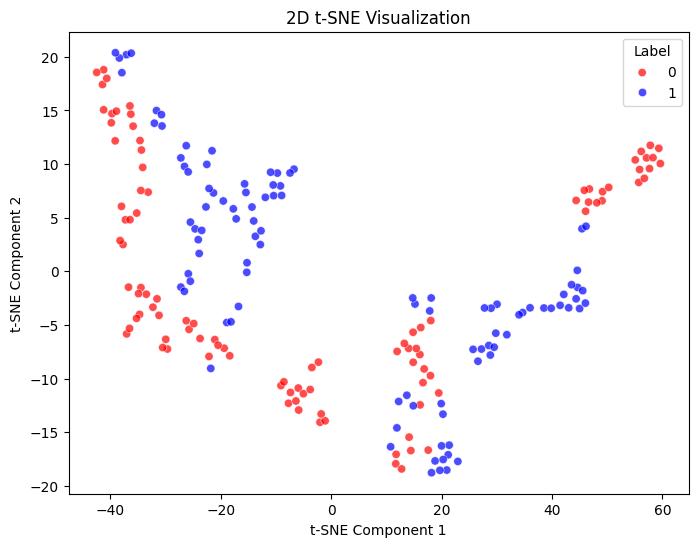

In [57]:
X = df.drop(columns=["index", "filename", "label", "width", "height"])
y = df["label"]  # 1 = FP, 0 = SP

# Step 2: Standardize Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

tsne = TSNE(n_components=2, perplexity=10, random_state=20)
X_tsne = tsne.fit_transform(X_scaled)

# Step 4: Convert to DataFrame for Plotting
df_tsne = pd.DataFrame(X_tsne, columns=["TSNE1", "TSNE2"])
df_tsne["label"] = y

# Step 5: Plot t-SNE Results
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_tsne,  # Pass DataFrame explicitly
    x="TSNE1", 
    y="TSNE2", 
    hue="label",  # Use column name directly
    palette=["blue", "red"], 
    alpha=0.7
)
plt.title("2D t-SNE Visualization")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Label", labels=["0", "1"])
plt.show()

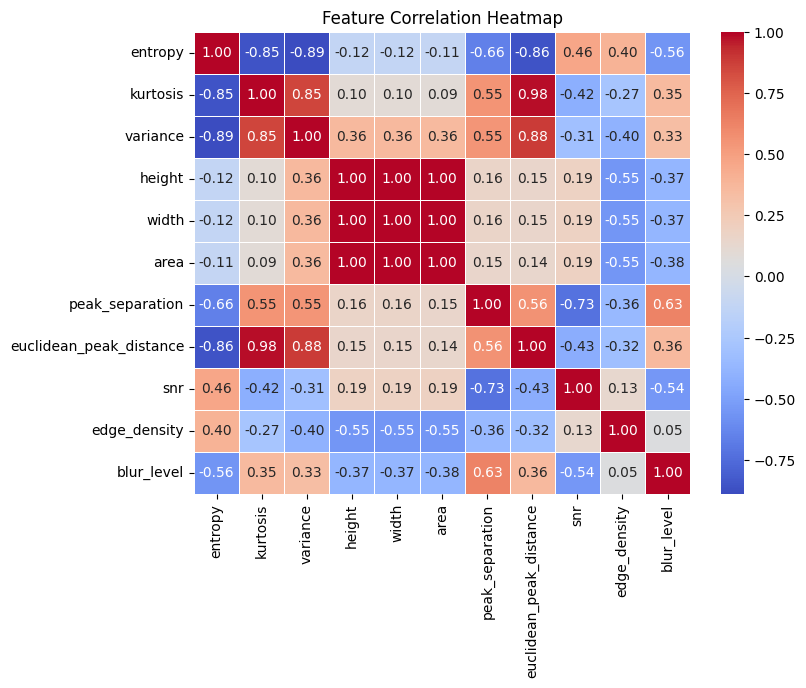

In [18]:
numeric_df = df.drop(columns=["index", "filename", "label"])

# Step 2: Compute Correlation Matrix
correlation_matrix = numeric_df.corr()

# Step 3: Plot Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Titles and Labels
plt.title("Feature Correlation Heatmap")
plt.show()

In [22]:
df.to_csv("feature_data.csv", index=False)

Text(0.5, 1.0, 'Index vs Blur Level')

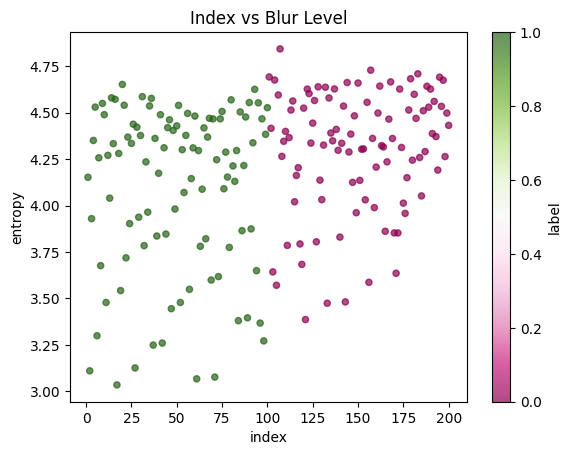

In [50]:
df.plot.scatter(x="index", y="entropy", c="label", colormap="PiYG", alpha=0.7)
plt.title("Index vs Blur Level")

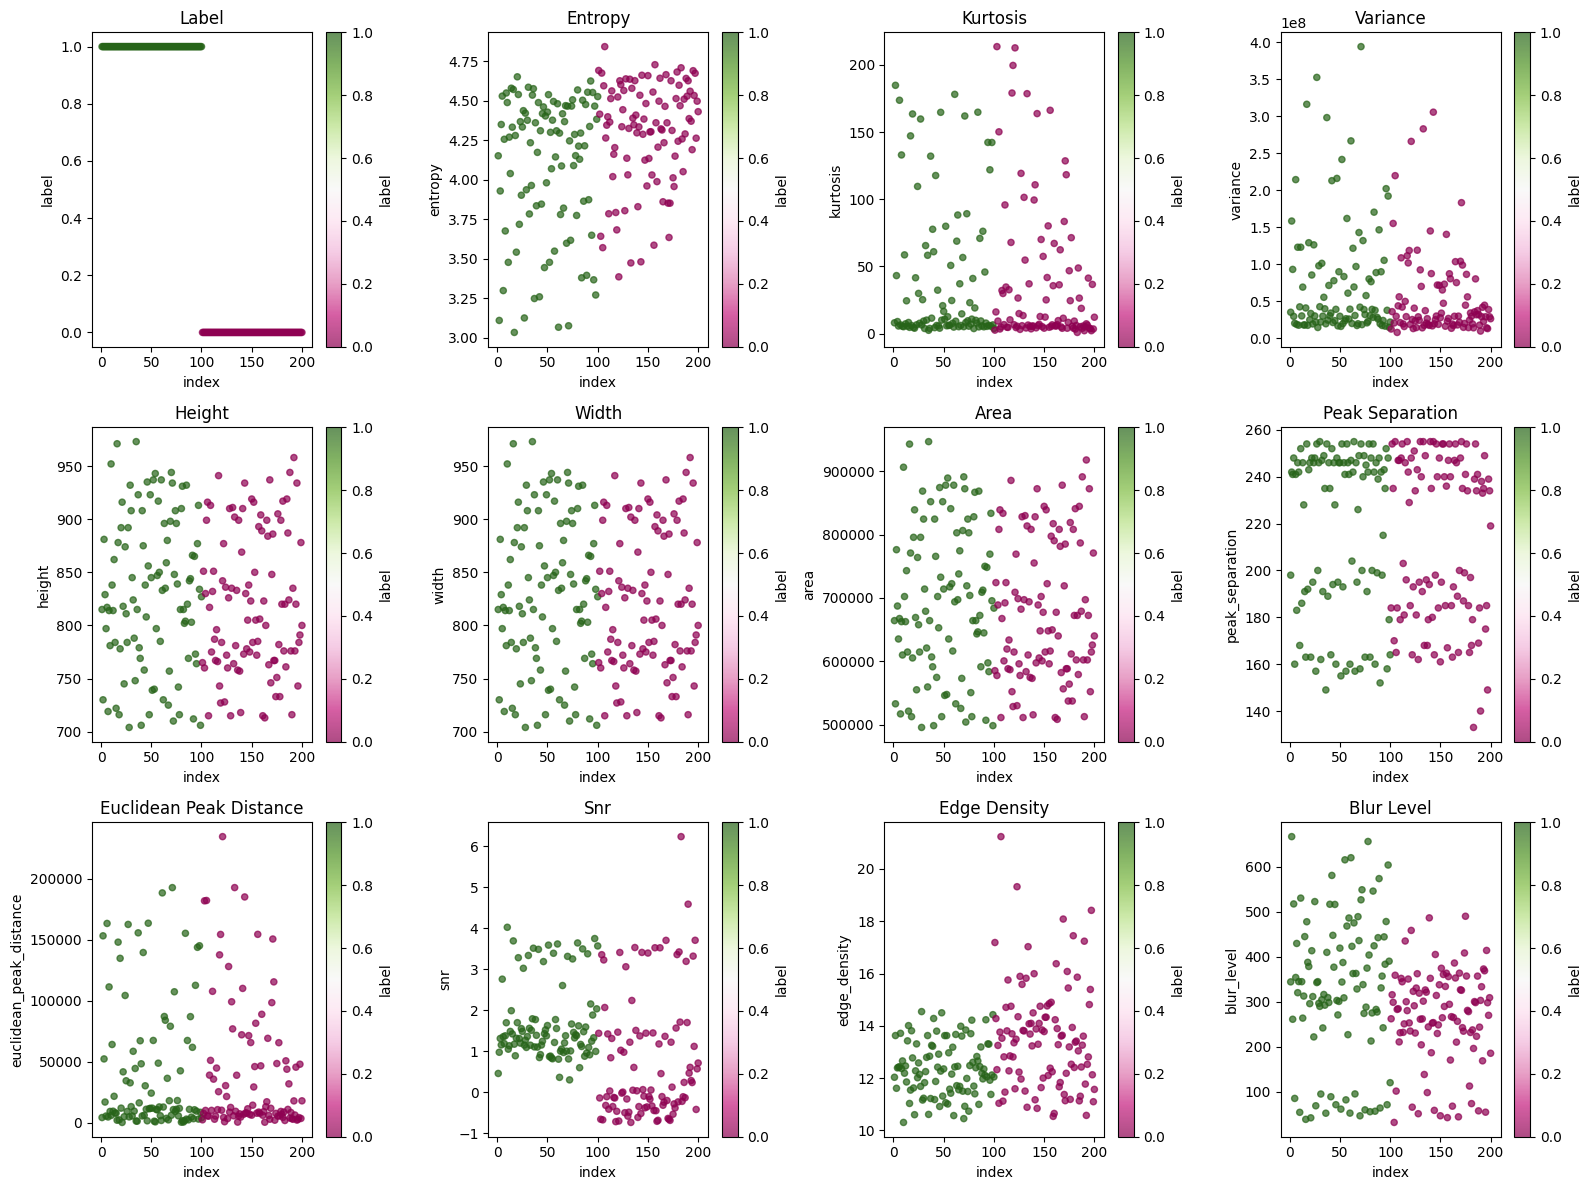

In [54]:
import matplotlib.pyplot as plt
import math

# Define the y-columns to plot (excluding 'index' and 'label')
y_columns = [col for col in df.columns if col not in ["index", "filename"]]

# Determine the grid size (4x4 or smaller based on y_columns count)
rows = math.ceil(len(y_columns) / 4)
cols = min(len(y_columns), 4)

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(16, rows * 4))

# Flatten axes for easy iteration (handles cases where there are fewer than 16 plots)
axes = axes.flatten()

# Plot each y column in a separate subplot
for i, y_col in enumerate(y_columns):
    df.plot.scatter(
        x="index", y=y_col, c="label", colormap="PiYG", alpha=0.7, ax=axes[i]
    )
    axes[i].set_title(y_col.replace("_", " ").title())  # Format title

# Hide any extra unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


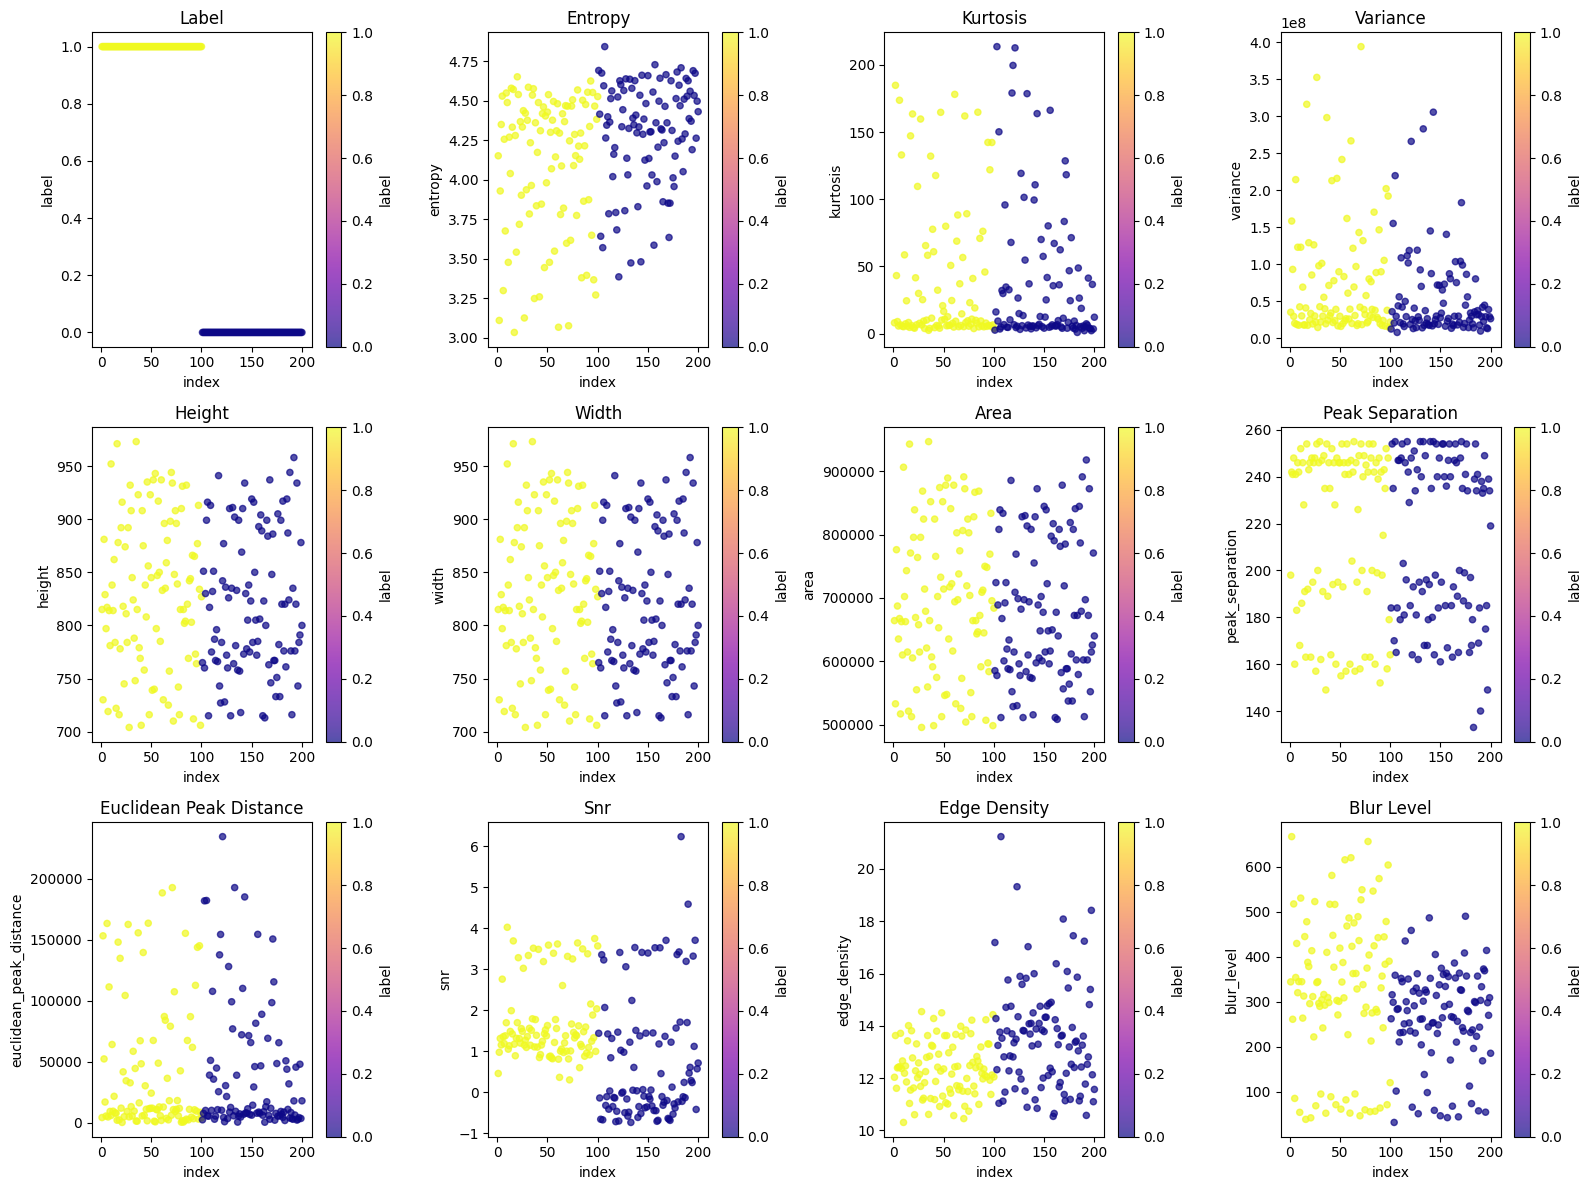

In [56]:
# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(16, rows * 4))

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot each y column in a separate subplot with a different colormap
for i, y_col in enumerate(y_columns):
    df.plot.scatter(
        x="index", y=y_col, c="label", colormap="plasma", alpha=0.7, ax=axes[i]
    )
    axes[i].set_title(y_col.replace("_", " ").title())  # Format title

# Hide any extra unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()